This notebook contains all code to reproduce results in the paper "Analyzing e-cigarette sentiment of Twitter", published in the Computational Health Sciences Workshop at the 6th ACM Conference on Bioinformatics, Computational Biology, and Health Informatics, 2015.

###Data

We begin with the data collected by Sherry Emery et al. <slemery@uic.edu>, which consists 4.6M tweets from 2012-10-01 to 2013-09-30. These tweets have already been classified as "organic" or not using an SVM classifier (see Huang, Jidong et al. "A cross-sectional examination of marketing of electronic cigarettes on Twitter." Tobacco control). We restrict our analysis to those classified as organic. We will assume these data live in `/data/chs15/ecig.csv.gz`.

In [7]:
from collections import Counter, defaultdict
import cPickle
import csv
import datetime
import gzip
import itertools
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import re
import requests
import scipy
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import string
from tabulate import tabulate

%matplotlib inline

DATA = '/data/chs15'

In [2]:
def read_csv(filename, fields=['text', 'svm', 'hand_label', 'posted_time', 'real_name', 'username']):
    f = gzip.open(filename, 'rb')
    csvr = csv.DictReader(f, delimiter=',', quotechar='"')
    for row in csvr:
        yield dict([(k, row[k]) for k in fields if k in row])

In [3]:
# Read all "organic" tweets.
raw_tweets = [r for r in read_csv(DATA + '/ecig.csv.gz') if r['svm'] == '-']
print('read %d "organic" tweets' % len(raw_tweets))

read 992633 "organic" tweets


Next, we manually labeled 2,000 tweets into one of two categories:
- **positive (1):** express positive sentiment toward ecigs, or indicate that the speaker uses ecigs.
- **negative (0):** express negative sentiment toward ecigs *or* do not express sentiment, e.g., informative

(We originally separated negative into two classes, but accuracy was too low to support further analysis.)

We assume these data live in `/data/chs15/labeled.csv.gz`.

In [88]:
labeled_tweets = [r for r in read_csv(DATA + '/labeled.csv.gz', fields=['text', 'sent', 'real_name', 'username'])]

print('read %d labeled tweets' % len(labeled_tweets))
# Set labels.

label_map = {'-1': 'negative', '0': 'negative', '1': 'positive'}
labels = ['negative', 'positive']
#label_map = {'-1': 'negative', '0': 'neutral', '1': 'positive'}
#labels = ['negative', 'neutral', 'positive']
for t in labeled_tweets:
    t['sent'] = label_map[t['sent']]
             
label_encoder = LabelEncoder()
label_encoder.fit(labels)
y = label_encoder.transform([t['sent'] for t in labeled_tweets])             
print('Label distribution=%s' % Counter(t['sent'] for t in labeled_tweets).most_common(3))

read 2000 labeled tweets
Label distribution=[('negative', 1296), ('positive', 704)]


### Classifier Training

Using `labeled_tweets`, we'll train a logistic regression classifier.

In [13]:
# Tweet tokenizer.
def tokenize(text):
    punc_re = '[' + re.escape(string.punctuation) + ']'
    text = text.lower()
    text = re.sub('#(\S+)', r'HASHTAG_\1', text)
    text = re.sub('@(\S+)', r'MENTION_\1', text)
    text = re.sub('http\S+', 'THIS_IS_A_URL', text)
    text = re.sub(r'(.)\1\1\1+', r'\1', text)
    text = re.sub(r'[0-9]', '9', text)
    toks = []
    for tok in text.split():
        tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
        tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
        for subtok in tok.split():
            if re.search('\w', subtok):
                toks.append(subtok)
    return toks

In [14]:
vectorizer = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 2), max_df=1., min_df=2,
                             use_idf=True, tokenizer=tokenize, binary=False, norm='l2')
X = vectorizer.fit_transform(t['text'] for t in labeled_tweets)
print('Vectorized %d tweets. Found %d terms.' % (X.shape[0], X.shape[1]))
features = np.array(vectorizer.get_feature_names())

Vectorized 2000 tweets. Found 4824 terms.


In [89]:
def confusion(truths, preds, labels):
    m = confusion_matrix(truths, preds)
    m = np.vstack((labels, m))
    m = np.hstack((np.matrix([''] + list(labels)).T, m))
    return tabulate(m.tolist(), headers='firstrow')

def top_coef(clf, vocab, n=10):
    if len(clf.classes_) == 2:
        coefs = [clf.coef_[0], -clf.coef_[0]]
    else:
        coefs = clf.coef_
    for li, label in enumerate(clf.classes_):
        print('\nCLASS %s' % label)
        coef = coefs[li]
        top_coef_ind = np.argsort(coef)[::-1][:n]
        top_coef_terms = vocab[top_coef_ind]
        top_coef = coef[top_coef_ind]
        print '\n'.join(['%s\t%.3f' % (term, weight) for term, weight in zip(top_coef_terms, top_coef)])

def do_cv(X, y, labels, nfolds=10):
    cv = KFold(len(y), nfolds, random_state=123456)
    preds = []
    truths = []
    for train, test in cv:
        clf = LogisticRegression(class_weight='auto')
        clf.fit(X[train], y[train])
        preds.extend(clf.predict(X[test]))
        truths.extend(y[test])
    print ('accuracy=%.3f' % (accuracy_score(truths, preds)))
    print classification_report(truths, preds, target_names=labels)
    print confusion(truths, preds, labels)
    clf = LogisticRegression(class_weight='auto')
    clf.fit(X, y)
    return clf, truths, preds

clf, truths, preds = do_cv(X, y, label_encoder.classes_, 10)
top_coef(clf, features, 5)

accuracy=0.793
             precision    recall  f1-score   support

   negative       0.84      0.83      0.84      1296
   positive       0.70      0.72      0.71       704

avg / total       0.79      0.79      0.79      2000

            negative    positive
--------  ----------  ----------
negative        1082         214
positive         199         505

CLASS 0
my	5.390
i	4.668
vaping	2.160
HASHTAG_vaping	1.722
HASHTAG_ecig	1.663

CLASS 1
THIS_IS_A_URL	4.017
e-cigarettes	1.940
de	1.171
as	1.164
99	1.112


In [16]:
# Write cross-validation results .tex table.
def clfreport_to_tex(report, outfile):
    """ Write a sklearn classification report as a latex table. """
    report = re.sub(r' \/ total', '', report)
    report = re.sub(r'precision', 'Prec', report)
    report = re.sub(r'recall', 'Rec', report)
    report = re.sub(r'f1-score', 'F1', report)
    report = re.sub(r'support', 'N', report)
    table = ['\\begin{tabular}{|r|c|c|c|c|}', '\\hline']
    lines = report.split('\n')
    for i, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) > 0:
            if i == 0:
                parts = [''] + ['{\\bf %s}' % p for p in parts]
            else:
                parts[0] = '{\\bf %s}' % parts[0]
            table.append(' & '.join(parts) + '\\\\')
        else:
            table.append('\\hline')
    table.append('\\end{tabular}')
    of = open(outfile, 'wt')
    of.write('\n'.join(table))
    
clfreport_to_tex(classification_report(truths, preds, target_names=labels), 'cv.tex')

In [90]:
# Write top coef .tex table.
def clean(s):
    s = re.sub('HASHTAG_', '\#', s)
    s = re.sub('MENTION_', '@', s)
    s = re.sub('THIS_IS_A_URL', 'URL', s)
    s = re.sub(r'_', '\\_', s)
    return s
    
def write_top_coef(clf, vocab, labels, outf, n=20):
    out = open(outf, 'wt')
    coefs = [-clf.coef_[0], clf.coef_[0]]
    for li, label in enumerate(labels):
        coef = coefs[li]
        top_coef_ind = np.argsort(coef)[::-1][:n]
        top_coef_terms = vocab[top_coef_ind]
        out.write('{\\bf %s} & %s\\\\\n\hline\n' % (label, ', '.join(clean(s) for s in top_coef_terms)))
        
write_top_coef(clf, features, labels, 'coef.tex', n=20)


### Applying classifier

Next, we classify all the unlabeled tweets using the classifier.

In [18]:
X_raw = vectorizer.transform(t['text'] for t in raw_tweets)

In [91]:
preds_raw = clf.predict(X_raw)
print('predicted label distribution on raw tweets: %s' % Counter(preds_raw).most_common(3))
for tweet, pred in zip(raw_tweets, preds_raw):
    tweet['sent'] = labels[pred]

predicted label distribution on raw tweets: [(0, 623396), (1, 369237)]


### Gender

Next, we classify each user by gender using a list of names from the census.

In [20]:
def get_gender_names(cutoff=75):
    males_url = 'http://www2.census.gov/topics/genealogy/1990surnames/dist.male.first'
    females_url = 'http://www2.census.gov/topics/genealogy/1990surnames/dist.female.first'
    males = set([l.split()[0].lower() for l in requests.get(males_url).text.split('\n') if l and float(l.split()[2]) < cutoff])
    females = set([l.split()[0].lower() for l in requests.get(females_url).text.split('\n') if l and float(l.split()[2]) < cutoff ])
    print('found %d male and %d female names with cutoff=%.2f' % (len(males), len(females), cutoff))
    return remove_ambiguous_names(males, females)

def remove_ambiguous_names(male_names, female_names):
    ambiguous = male_names & female_names
    male_names -= ambiguous
    female_names -= ambiguous
    print('removed %d ambiguous names, leaving %d males and %d females' % (len(ambiguous), len(male_names), len(female_names)))
    return male_names, female_names
    
male_names, female_names = get_gender_names()

found 232 male and 523 female names with cutoff=75.00
removed 6 ambiguous names, leaving 226 males and 517 females


In [21]:
def label_genders(tweets, male_names, female_names):
    for t in tweets:
        if len(t['real_name'])>1:
            first = t['real_name'].split()[0].lower()
        else:
            first = t['real_name'].lower()
        if first in male_names:
            t['gender'] = 'male'
        elif first in female_names:
            t['gender'] = 'female'
        else:
            t['gender'] = 'unknown'
label_genders(raw_tweets, male_names, female_names)
print('overall gender distribution=%s' % Counter(t['gender'] for t in raw_tweets).most_common(3))

overall gender distribution=[('unknown', 732856), ('male', 156902), ('female', 102875)]


In [22]:
print('most common male names: %s' % Counter(t['real_name'].split()[0] for t in raw_tweets if t['gender'] == 'male').most_common(10))
print('most common female names: %s' % Counter(t['real_name'].split()[0] for t in raw_tweets if t['gender'] == 'female').most_common(10))
print('most common unknown names: %s' % Counter(t['real_name'].split()[0] for t in raw_tweets if t['real_name'] and t['gender'] == 'unknown').most_common(10))

most common male names: [('Mark', 9017), ('Paul', 4531), ('John', 4393), ('Michael', 3748), ('Chris', 3662), ('Adam', 3539), ('Alex', 3215), ('Gregory', 2916), ('David', 2747), ('James', 2732)]
most common female names: [('Sarah', 2007), ('Ashley', 1399), ('Jessica', 1320), ('Emily', 1318), ('Rachel', 1212), ('Amanda', 1208), ('Katie', 1121), ('Laura', 1116), ('Mandy', 1087), ('Lauren', 1084)]
most common unknown names: [('Electronic', 15305), ('Dragonfly', 14279), ('The', 5898), ('Lewisville', 4837), ('g', 4588), ('Vapornine', 4105), ('Matt', 3573), ('?', 3237), ('DFW', 2904), ('Nick', 2466)]


### Age

To guess age from a user's name, we use the idea from from [Nate Silver's](https://twitter.com/FiveThirtyEight) recent article on [How to Tell Someone's Age When All you Know is Her Name](http://fivethirtyeight.com/features/how-to-tell-someones-age-when-all-you-know-is-her-name/). We borrow from [this notebook](https://github.com/ramnathv/agebyname_py) by [@ramnathv](https://github.com/ramnathv).

First, we download a list of [baby names](http://www.ssa.gov/oact/babynames/names.zip) provided by the SSA.

In [23]:
import urllib
names_file = DATA + '/names.zip'
urllib.urlretrieve('http://www.ssa.gov/oact/babynames/names.zip', DATA + '/names.zip')

('/data/chs15/names.zip', <httplib.HTTPMessage instance at 0x11b892680>)

In [24]:
# Read list of names.
import pandas as pd
from zipfile import ZipFile

def read_names(f, zf):
  data = pd.read_csv(zf.open(f), header = None, names = ['name', 'sex', 'n'])
  data['year'] = int(re.findall(r'\d+', f)[0])
  return data
  
names_zip = ZipFile(names_file)
bnames = pd.concat([read_names(f, names_zip) for f in names_zip.namelist() if f.endswith('.txt')])
names_ =  set(bnames.name)
bnames.head()

,name,sex,n,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


Next we parse the [cohort life tables](http://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_7.html) provided by SSA, using @ramnathv's export.

In [25]:
from scipy.interpolate import interp1d

lifetables = pd.read_csv(DATA + '/lifetables.csv')
lifetables_2014 = lifetables[lifetables['year'] + lifetables['x'] == 2014]
lifetables_2014.head()

# interpolate gaps
def process(d, kind = 'slinear'):
  f = interp1d(d.year, d.lx, kind)
  year = np.arange(1900, 2011)
  lx = f(year)
  return pd.DataFrame({"year": year, "lx": lx, "sex": d.sex.iloc[1]})

lifetable_2014 = lifetables_2014.\
  groupby('sex', as_index = False).\
  apply(process)
lifetable_2014.head()

lx sex  year
0 0   0.0   F  1900
  1  19.1   F  1901
  2  38.2   F  1902
  3  57.3   F  1903
  4  76.4   F  1904

Finally, we use the [live births data](http://www.census.gov/statab/hist/02HS0013.xls) from the census to extrapolate the birth data to account for the correct that not all births were recorded by SSA till around 1930, since it wasn't mandatory.

In [26]:
# Download the data and add a correction factor.
urllib.urlretrieve("http://www.census.gov/statab/hist/02HS0013.xls", DATA + "/02HS0013.xls")
dat = pd.read_excel(DATA + '/02HS0013.xls', sheetname = 'HS-13', skiprows = range(14))
tot_births = dat.ix[9:101,:2].reset_index(drop = True)
tot_births.columns = ['year', 'births']
tot_births = tot_births.convert_objects(convert_numeric = True)
print tot_births.head()
# Correction factors.
cor_factors = bnames.groupby('year', as_index = False).sum().merge(tot_births)
cor_factors['cor'] = cor_factors['births']*1000/cor_factors['n']
cor_factors = cor_factors[['year', 'cor']]
cor_new = pd.DataFrame({
  'year': range(2002, 2014),
  'cor': cor_factors.cor.iloc[-1]
})
cor_factors = pd.concat([cor_factors, cor_new])[['year', 'cor']]
print cor_factors.head()

   year  births
0  1909    2718
1  1910    2777
2  1911    2809
3  1912    2840
4  1913    2869
   year       cor
0  1909  5.316621
1  1910  4.701051
2  1911  4.359994
3  1912  2.874354
4  1913  2.523141


In [27]:
# For efficiency, define name as index of the table
bname= bnames.set_index(['name'], inplace=True)

In [28]:
# This function tells the number of births and number of people alive. 
def get_data(name):
    dat = bnames
    dat = dat.loc[name]
    if type(dat) == pd.Series:
        m = pd.DataFrame(bnames.loc[name]).transpose()
    else:
        m = dat
    data =   m.\
            merge(cor_factors).\
            merge(lifetable_2014)
    data['n_cor'] = data['n']*data['cor']
    data['n_alive'] = data['lx']/(10**5)*data['n_cor']
    return data

print('Joseph')
print get_data('Edward').tail()
print('Irene')
print get_data('Irene').tail()

Joseph
    sex     n  year       cor       lx        n_cor      n_alive
193   F     7  2007  1.076384  99351.7     7.534690     7.485842
194   M  2820  2007  1.076384  99221.6  3035.403577  3011.775996
195   M  2783  2008  1.076384  99256.4  2995.577360  2973.302247
196   M  2979  2009  1.076384  99291.2  3206.548673  3183.820656
197   M  2898  2010  1.076384  99326.0  3119.361549  3098.337052
Irene
    sex    n  year       cor       lx       n_cor     n_alive
169   F  492  2006  1.076384  99324.6  529.581050  526.004259
170   F  467  2007  1.076384  99351.7  502.671443  499.412624
171   F  482  2008  1.076384  99378.8  518.817207  515.594315
172   F  479  2009  1.076384  99405.9  515.588054  512.524946
173   F  408  2010  1.076384  99433.0  439.164773  436.674709


In [125]:
# Now we can map each name to a distribution over age brackets.
def first_name(name):
    if len(name) > 1:
        name = name.split()[0].lower().title()
    else:
        name = name.lower().title()
    return name


def age_brackets(name):    
    name = first_name(name)
    dic = defaultdict(list)
    #
    s=0 
    s1=0
    s2=0
    s3=0
    s4=0
    s5=0
    #fraction of percentages
    f=0  
    f1=0
    f2=0
    f3=0
    f4=0    
    f5=0
    
    m = get_data(name).as_matrix()
    if len(m) != 0:
        for t in m:
            if t[2]>=1996: # 0-18
                s = s+t[1]
                f = f + t[6]
                dic['<18'] = f
            elif t[2] >= 1990 and t[3]<=1995: #19-24
                s1 = s1+t[1]
                f1 = f1 + t[6]
                dic['18-24'] = f1
            elif t[2] >= 1980 and t[3]<=1989: #25-34
                s2 = s2+t[1]
                f2 = f2 + t[6]
                dic['25-34'] = f2
            elif t[2] >= 1970 and t[3]<=1979: #35-44
                s3 = s3+t[1]
                f3 = f3 + t[6]
                dic['35-44'] = f3
            elif t[2] <= 1960 :#and t[2] <= 1969: #45-54
                s4 = s4+t[1]
                f4 = f4 + t[6]
                dic['>=45'] = f4
        #d = pd.DataFrame(dic.values(),dic.keys(), columns=['n','n_alive'])
        #d['fraction']= (d['n_alive']/d['n_alive'].sum())*100        
        #print d
        #print dic
        total = sum(dic.values())
        return dict([(k, 1.*v/total*100) for k, v in dic.iteritems()])
    
print('Irene')
print age_brackets('Irene')
print('Michael')
print age_brackets('Michael')
print('Payton')
print age_brackets('Payton')

Irene
{'35-44': 5.9900770087280355, '>=45': 79.96979901362864, '18-24': 2.768896935891503, '25-34': 5.300358368654281, '<18': 5.970868673097543}
Michael
{'35-44': 21.724002632069023, '>=45': 33.05996262251043, '18-24': 10.25125353909169, '25-34': 21.20556963381044, '<18': 13.759211572518417}
Payton
{'35-44': 0.4265604073936273, '>=45': 0.5359894837394966, '18-24': 6.8700057813423445, '25-34': 1.2200035112432313, '<18': 90.9474408162813}


In [126]:
def label_ages(tweets, valid_names):
    name_cache = {}
    for ti, t in enumerate(tweets):
        name = first_name(t['real_name'])
        if name in valid_names:
            if name in name_cache:
                distr = name_cache[name]
            else:
                distr = age_brackets(name)
                name_cache[name] = distr
            t['ages'] = distr
        
        if ti % 10000 == 0:
            print('processed %d tweets' % ti)
        ti += 1
        
label_ages(raw_tweets, names_)

processed 0 tweets
processed 10000 tweets
processed 20000 tweets
processed 30000 tweets
processed 40000 tweets
processed 50000 tweets
processed 60000 tweets
processed 70000 tweets
processed 80000 tweets
processed 90000 tweets
processed 100000 tweets
processed 110000 tweets
processed 120000 tweets
processed 130000 tweets
processed 140000 tweets
processed 150000 tweets
processed 160000 tweets
processed 170000 tweets
processed 180000 tweets
processed 190000 tweets
processed 200000 tweets
processed 210000 tweets
processed 220000 tweets
processed 230000 tweets
processed 240000 tweets
processed 250000 tweets
processed 260000 tweets
processed 270000 tweets
processed 280000 tweets
processed 290000 tweets
processed 300000 tweets
processed 310000 tweets
processed 320000 tweets
processed 330000 tweets
processed 340000 tweets
processed 350000 tweets
processed 360000 tweets
processed 370000 tweets
processed 380000 tweets
processed 390000 tweets
processed 400000 tweets
processed 410000 tweets
proces

In [127]:
def add_to_dict(d, d1):
    for k in d1:
        d[k] += d1[k]
    
all_ages = defaultdict(lambda: 0)
for t in raw_tweets:
    if 'ages' in t and t['ages']:
        add_to_dict(all_ages, t['ages'])
        
print 'overall ages:'
for k, v in all_ages.iteritems():
    print('%s\t%.2f' % (k, v / sum(all_ages.values())))

overall ages:
25-34	0.16
>=45	0.27
18-24	0.12
35-44	0.14
<18	0.30


In [128]:
# Assign each tweet its most probable age.
age_counts = defaultdict(lambda: 0)
for t in raw_tweets:
    if 'ages' in t and t['ages'] is not None and len(t['ages']) > 0:
        items = t['ages'].items()
        pred_age = items[np.argmax([it[1] for it in items])][0]
        t['pred_age'] = pred_age
        age_counts[pred_age] += 1
    
for a in ['<18', '18-24', '25-34', '35-44', '>=45']:
    print a, age_counts[a]

<18 210325
18-24 13613
25-34 61475
35-44 46411
>=45 204490


In [129]:
# Save our annotated tweets.
cPickle.dump(raw_tweets, open(DATA + '/raw_tweets.pkl', 'wb'))

### Figures

Next we create a number of figures to explore how ecig sentiment varies by time, gender, and age.

In [130]:
def format_month(datestring):
    """ Input, e.g., 10/1/2012
    Output, e.g., 2012-10"""
    parts = datestring.split()
    if len(parts) > 1:
        datestring = parts[0]
        parts = datestring.split('/')
        if len(parts) == 3:
            s = (parts[2] if len(parts[2]) == 4 else '20' + parts[2]) + \
            '-' + (parts[0] if len(parts[0]) == 2 else '0' + parts[0])
            return datetime.datetime.strptime(s, "%Y-%m").date()
    return None

def group_by_month(tweets):
    by_month = defaultdict(lambda: [])
    for t in tweets:
        t['month'] = format_month(t['posted_time'])
        by_month[t['month']].append(t)
    return by_month
    
by_month = group_by_month(raw_tweets)

In [34]:
print '\n'.join(['%s\t%d' % (m, len(by_month[m])) for m in sorted(by_month)])

2012-10-01	30026
2012-11-01	36995
2012-12-01	46271
2013-01-01	62883
2013-02-01	65971
2013-03-01	90870
2013-04-01	110735
2013-05-01	84692
2013-06-01	96447
2013-07-01	94180
2013-08-01	114894
2013-09-01	158669


In [52]:
def check_keyvals(t, keyvals):
    for keyval in keyvals:
        if keyval[0] not in t or t[keyval[0]] != keyval[1]:
            return False
    return True

def filter_tweets(tweets, ignore_rt=True, uniq_users=True, keyvals=None):
    return np.array(tweets)[filter_tweets_ind(tweets, ignore_rt, uniq_users, keyvals)]

def filter_tweets_ind(tweets, ignore_rt=True, uniq_users=True, keyvals=None):
    users = set()
    indices = []
    for i, t in enumerate(tweets):
        if ignore_rt and t['text'][:2] == 'RT':
            continue
        elif uniq_users and t['username'] in users:
            continue
        else:
            if keyvals and not check_keyvals(t, keyvals):
                continue
            users.add(t['username'])
            indices.append(i)
    return indices

In [83]:
def count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=None):
    vals = []
    for month in sorted(by_month):
        vals.append(len(filter_tweets(by_month[month], ignore_rt, uniq_users, keyvals)))
    return np.array(vals)

In [37]:
def get_lines():
    markers = ['o', '^', 's', '*', 'D', '^', 's', '*', 'D', 'o']
    lines = ['-', '--', '-.', ':'] * 3
    return itertools.cycle(['%s%s' % (m, l) for l, m in zip(lines, markers)])

male 47.3473990884
female 49.5029371893
<18 49.8270731896
18-24 48.4101748808
25-34 52.0260564557
35-44 50.1957634776
>=45 46.2230751809


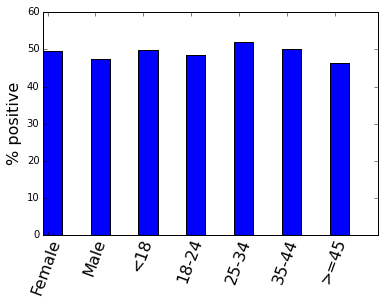

In [132]:
def plot_frac_pos(raw_tweets):
    male_pos_frac = 100. * len(filter_tweets(raw_tweets, keyvals=[['sent', 'positive'], ['gender', 'male']])) / len(filter_tweets(raw_tweets, keyvals=[['gender', 'male']]))
    female_pos_frac = 100. * len(filter_tweets(raw_tweets, keyvals=[['sent', 'positive'], ['gender', 'female']])) / len(filter_tweets(raw_tweets, keyvals=[['gender', 'female']]))    
    print 'male', male_pos_frac
    print 'female', female_pos_frac
    vals = [female_pos_frac, male_pos_frac]
    ages = ['<18', '18-24', '25-34', '35-44', '>=45']
    for a in ages:
        frac = 100. * len(filter_tweets(raw_tweets, keyvals=[['sent', 'positive'], ['pred_age', a]])) / len(filter_tweets(raw_tweets, keyvals=[['pred_age', a]]))
        print a, frac
        vals.append(frac)
        
    plt.figure()
    xvals = np.arange(len(ages) + 2)
    plt.bar(xvals, vals, .4)
    plt.xticks(xvals + .1, ['Female', 'Male'] + ages, size=16)
    plt.ylabel('% positive', size=16)
    plt.xticks(rotation=70) 
    plt.savefig('pct_pos.pdf', bbox_inches='tight')
    plt.show()
        
    
plot_frac_pos(raw_tweets)

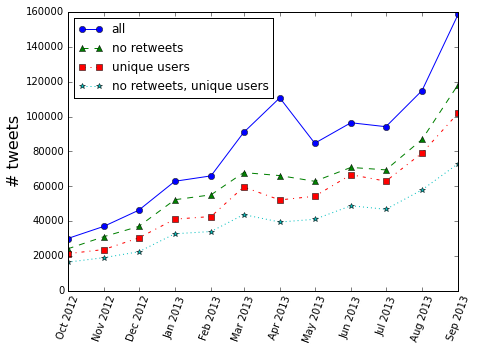

In [133]:
def plot_raw_counts(by_month):
    linecycler = get_lines()
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    ax.plot(months, count_tweets(by_month, ignore_rt=False, uniq_users=False), next(linecycler), label='all')
    ax.plot(months, count_tweets(by_month, ignore_rt=True, uniq_users=False), next(linecycler), label='no retweets')
    ax.plot(months, count_tweets(by_month, ignore_rt=False, uniq_users=True), next(linecycler), label='unique users')
    ax.plot(months, count_tweets(by_month, ignore_rt=True, uniq_users=True), next(linecycler), label='no retweets, unique users')
    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.legend(loc='upper left')
    plt.ylabel('# tweets', size=16)
    plt.savefig('raw_counts.pdf', bbox_inches='tight')
    plt.show()
    
plot_raw_counts(by_month)

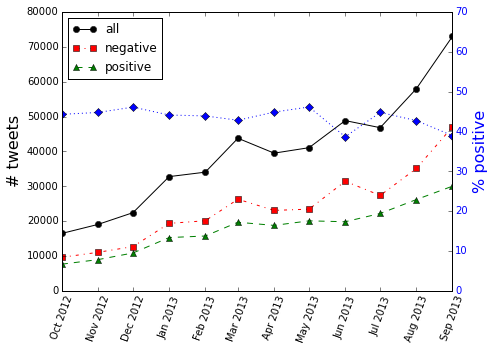

In [134]:
def plot_sentiment(by_month):
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    all_counts = count_tweets(by_month, ignore_rt=True, uniq_users=True)
    pos_counts = count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=[['sent', 'positive']])
    neg_counts = count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=[['sent', 'negative']])
    pos_fraction = 100. * pos_counts / (pos_counts + neg_counts)
    #pos_fraction = 100. * np.array(pos_counts) / np.array(all_counts)
    ax.plot(months, all_counts , 'ko-', label='all')
    #ax.plot(months, neut_counts , 'ko-', label='neutral')
    ax.plot(months, neg_counts, 'rs-.', label='negative')
    ax.plot(months, pos_counts, 'g^--', label='positive')

    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.legend(loc='upper left')

    ax2 = ax.twinx()
    ax2.plot(months, pos_fraction, 'bD:')
    ax2.set_ylabel('% positive', color='b', size=16)
    ax2.set_ylim((0, 70))
    for tl in ax2.get_yticklabels():
        tl.set_color('b')

    ax.set_ylabel('# tweets', size=16)
    plt.savefig('sentiment.pdf', bbox_inches='tight')
    plt.show()    
    
plot_sentiment(by_month)

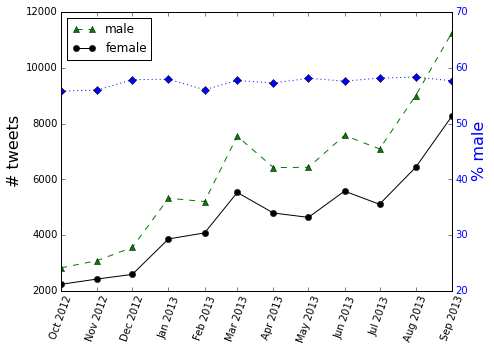

In [135]:
def plot_genders(by_month):
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    female_counts = count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=[['gender', 'female']])
    male_counts = count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=[['gender', 'male']])
    ax.plot(months, male_counts, 'g^--', label='male')
    ax.plot(months, female_counts , 'ko-', label='female')
    male_fraction = 100. * np.array(male_counts) / (np.array(male_counts) + np.array(female_counts))

    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.legend(loc='upper left')
    ax.set_ylabel('# tweets', size=16)
    
    ax2 = ax.twinx()
    ax2.plot(months, male_fraction, 'bD:')
    ax2.set_ylabel('% male', color='b', size=16)
    ax2.set_ylim((20, 70))
    for tl in ax2.get_yticklabels():
        tl.set_color('b')

    ax.set_ylabel('# tweets', size=16)

    plt.savefig('gender.pdf', bbox_inches='tight')
    plt.show()    
    
plot_genders(by_month)

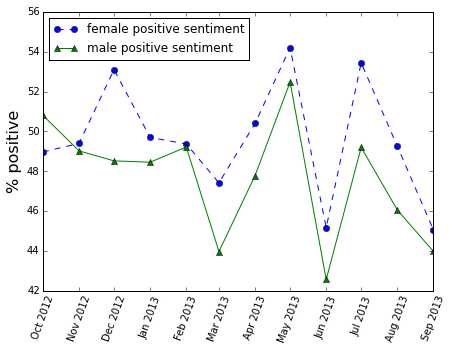

In [136]:
def plot_gender_sentiment(by_month):
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    male_pos = count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=[['gender', 'male'], ['sent', 'positive']])
    male = count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=[['gender', 'male']])
    female_pos = count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=[['gender', 'female'], ['sent', 'positive']])
    female = count_tweets(by_month, ignore_rt=True, uniq_users=True, keyvals=[['gender', 'female']])
    ax.plot(months, 100. * np.array(female_pos) / (np.array(female)) , 'bo--', label='female positive sentiment')
    ax.plot(months, 100. * np.array(male_pos) / (np.array(male)) , 'g^-', label='male positive sentiment')
    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.legend(loc='upper left')
    ax.set_ylabel('% positive', size=16)
    plt.savefig('gender_sentiment.pdf', bbox_inches='tight')
    plt.show()    
    
plot_gender_sentiment(by_month)

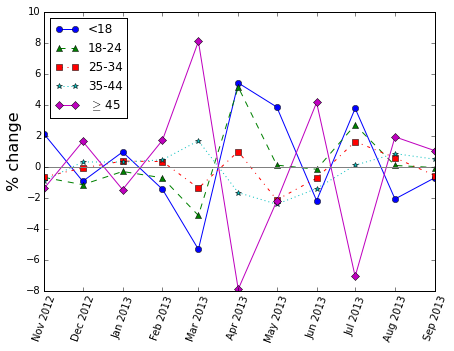

In [171]:
def count_ages(by_month, ignore_rt=True, uniq_users=True, keyvals=None):
    ages = []
    for month in sorted(by_month):
        sums = defaultdict(lambda: 0)
        matches = 0
        for t in filter_tweets(by_month[month], ignore_rt, uniq_users, keyvals):
            if 'ages' in t and t['ages'] is not None:
                add_to_dict(sums, t['ages'])
                matches += 1
        total = sum(sums.values())
        for k in sums:
            sums[k] /= total
        #for k in sums:
        #    sums[k] /= matches
        ages.append(sums)
    return ages

def pct_change(vals):
    return [100. * (v2-v1) / v1 for v1, v2 in zip(vals, vals[1:])]

def clean_age(a):
    if '45' in a:
        return '$\geq$ 45'
    else:
        return a

def plot_ages(by_month):
    lines = get_lines()
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    ages = count_ages(by_month, ignore_rt=True, uniq_users=True)    
    for a in ['<18', '18-24', '25-34', '35-44', '>=45']: # sorted(ages[0].keys()):
        #ax.plot(months, [x[a] for x in ages], next(lines), label=a)
        ax.plot(months[1:], pct_change([x[a] for x in ages]), next(lines), label=clean_age(a))
    ax.xaxis_date()
    plt.axhline(color='gray')
    plt.xticks(rotation=70) 
    plt.legend(loc='upper left')
    ax.set_ylabel('% change', size=16)
    
    plt.savefig('ages.pdf', bbox_inches='tight')
    plt.show()    
    
plot_ages(by_month)

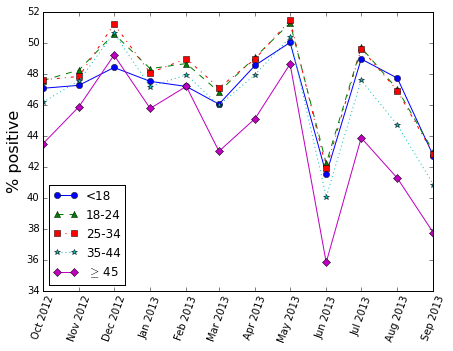

In [172]:
def count_age_sentiment(by_month, ignore_rt=True, uniq_users=True, keyvals=None):
    ages = []
    for month in sorted(by_month):
        sums_pos = defaultdict(lambda: 0)
        sums_neg = defaultdict(lambda: 0)
        matches = 0
        for t in filter_tweets(by_month[month], ignore_rt, uniq_users, keyvals):
            if 'ages' in t and t['ages'] is not None:
                if t['sent'] == 'positive':
                    add_to_dict(sums_pos, t['ages'])
                else:
                    add_to_dict(sums_neg, t['ages'])
                matches += 1
                
        pct_pos = dict()
        for k in sums_pos:
            pct_pos[k] = 100. * sums_pos[k] / (sums_neg[k] + sums_pos[k])
        ages.append(pct_pos)
    return ages

def plot_age_sentiment(by_month):
    lines = get_lines()
    months = [d for d in sorted(by_month)]
    plt.figure(figsize=(7,5))
    ax = plt.subplot(111)
    ages = count_age_sentiment(by_month, ignore_rt=True, uniq_users=True)    
    for a in ['<18', '18-24', '25-34', '35-44', '>=45']: # sorted(ages[0].keys()):
        ax.plot(months, [x[a] for x in ages], next(lines), label=clean_age(a))
        #ax.plot(months[1:], pct_change([x[a] for x in ages]), next(lines), label=a)
    ax.xaxis_date()
    plt.xticks(rotation=70) 
    plt.legend(loc='lower left')
    ax.set_ylabel('% positive', size=16)
    
    plt.savefig('age_sentiment.pdf', bbox_inches='tight')
    plt.show()    
    
plot_age_sentiment(by_month)

### Print top coefficients for each demographic/sentiment

In [75]:
def feat_counts(fi,ci,X,y):
    return sum([1 for (xs,yi) in zip(X,y) if yi == ci and xs[fi] > 0])

def get_pos_mask(X, y, feats, reg=1):
    """ Get mask for indices that are more associated with class 1 than class 0. """
    posp = ((1 + X[np.where(y == 1)].sum(axis=0)) / X[np.where(y == 1)].sum()).getA1()
    negp = ((1 + X[np.where(y == 0)].sum(axis=0)) / X[np.where(y == 0)].sum()).getA1()
    diffs = posp - negp
    diffs = np.array([1 if v > 0 else 0 for v in diffs])
    return np.array(diffs)
    
    
def top_terms(X_real, target_ind, base_ind, feats, n=15):
    base_ind = np.array(list(set(base_ind) - set(target_ind)))
    print '%d target and %d base indices' % (len(target_ind), len(base_ind))
    X = X_real.sign()
    subX = X[np.concatenate((target_ind, base_ind))]
    y = np.array([1] * len(target_ind) + [0] * len(base_ind))
    probs = get_pos_mask(subX, y, feats)
    chi, _ = chi2(subX, y)
    chi = np.nan_to_num(chi * probs)
    found = 0
    result = []
    for feat in feats[np.argsort(chi)[::-1]]:
        if ' ' not in feat:
            result.append(feat)
            found += 1
        if found == n:
            break
    return result

In [173]:
def join_terms(terms):
    return ', '.join(clean(s) for s in terms)

def print_term_table(X_raw, raw_tweets, by_month, outf):        
    out = open(outf, 'wt')
    out.write('{\\bf Positive sentiment} & %s\\\\\n' % 
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive']]),
                filter_tweets_ind(raw_tweets, keyvals=[['sent', 'negative']]), features)))
    out.write('{\\bf Negative sentiment} & %s\\\\\n' %
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['sent', 'negative']]),
                filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive']]), features)))
    out.write('\\hline\n')
    out.write('{\\bf Female} & %s\\\\\n' % 
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['gender', 'female']]),
                filter_tweets_ind(raw_tweets, keyvals=[['gender', 'male']]), features)))
    out.write('{\\bf Male} & %s\\\\\n' % 
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['gender', 'male']]),
                filter_tweets_ind(raw_tweets, keyvals=[['gender', 'female']]), features)))
    out.write('\\hline\n')
    #out.write('{\\bf Female Positive} & %s\\\\\n' % 
    #            join_terms(top_terms(X_raw,
    #                                 filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive'], ['gender', 'female']]),
    #                                 [i for i, t in enumerate(raw_tweets) if 'gender' in t], features)))
    #out.write('{\\bf Male Positive} & %s\\\\\n' % 
    #            join_terms(top_terms(X_raw,
    #                                 filter_tweets_ind(raw_tweets, keyvals=[['sent', 'positive'], ['gender', 'male']]),
    #                                 [i for i, t in enumerate(raw_tweets) if 'gender' in t], features)))
    #out.write('\\hline\n')
    for age in ['<18', '18-24', '25-34', '35-44', '>=45']:
        out.write('{\\bf %s} & %s\\\\\n' % (clean_age(age),
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['pred_age', age]]),
                                            [i for i, t in enumerate(raw_tweets) if 'pred_age' in t], features))))
    out.write('\\hline\n')
    for month in sorted(by_month):
        out.write('{\\bf %s} & %s\\\\\n' % (str(month)[:7],
                join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['month', month]]),
                                            range(len(raw_tweets)), features))))
        
    #out.write('\\hline\n')
    #for age in ['<18', '19-24', '25-34', '35-44', '>45']:
    #    out.write('{\\bf %s Positive} & %s\\\\\n' % (age,
    #            join_terms(top_terms(X_raw, filter_tweets_ind(raw_tweets, keyvals=[['pred_age', age], ['sent', 'positive']]),
    #                                        [i for i, t in enumerate(raw_tweets) if 'pred_age' in t], features))))

    out.close()
    
print_term_table(X_raw, raw_tweets, by_month, 'coef_demo.tex')


182235 target and 247776 base indices
247776 target and 182235 base indices
48686 target and 63843 base indices
63843 target and 48686 base indices
103512 target and 432802 base indices
6290 target and 530024 base indices
29935 target and 506379 base indices
19922 target and 516392 base indices
83891 target and 452423 base indices
16487 target and 976146 base indices
19070 target and 973563 base indices
22446 target and 970187 base indices
32778 target and 959855 base indices
34054 target and 958579 base indices
43777 target and 948856 base indices
39506 target and 953127 base indices
41072 target and 951561 base indices
48838 target and 943795 base indices
46806 target and 945827 base indices
57973 target and 934660 base indices
72994 target and 919639 base indices
